In [10]:
import numpy as np
import pandas as pd
import warnings
import os

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.compat.v1.keras.layers import TimeDistributed


warnings.simplefilter('ignore')

countryName = 'Brazil'

nFeatures = 1

nDaysMin = 3
k = 7

nValid = 10
nTest = 10

In [11]:
dataDir = os.path.join('C:\\Users\\AMC\\Desktop\\Roshi\\Data')
confirmedFilename = 'confirmed_july.csv'
deathsFilename = 'deaths_july.csv'
recoveredFilename = 'recovered_july.csv'

In [12]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, k):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix + k >= len(sequence):
            break
        # input and output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+k]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [13]:
def meanAbsolutePercentageError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    absPcErrorList = [absError/yTrue for absError, yTrue in zip(absErrorList, yTrueList)]
    MAPE = 100*np.mean(absPcErrorList)
    return MAPE

def meanAbsolutePercentageError_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
            
    # Get MAPE for each day in a list
    MAPEList = []
    for i in yTrueForDayK.keys():
        MAPEList.append(meanAbsolutePercentageError(yTrueForDayK[i], yPredForDayK[i]))
    return np.mean(MAPEList)

def meanForecastError(yTrueList, yPredList):
    forecastErrors = [yTrue - yPred for yTrue, yPred in zip(yTrueList, yPredList)]
    MFE = np.mean(forecastErrors)
    return MFE

def meanAbsoluteError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(absErrorList)

def meanSquaredError(yTrueList, yPredList):
    sqErrorList = [np.square(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(sqErrorList)

def rootMeanSquaredError(yTrueList, yPredList):
    return np.sqrt(meanSquaredError(yTrueList, yPredList))
def medianSymmetricAccuracy(yTrueList, yPredList):
    '''https://helda.helsinki.fi//bitstream/handle/10138/312261/2017SW001669.pdf?sequence=1'''
    logAccRatioList = [np.abs(np.log(yPred/yTrue)) for yTrue, yPred in zip(yTrueList, yPredList)]
    MdSA = 100*(np.exp(np.median(logAccRatioList))-1)
    return MdSA

def medianSymmetricAccuracy_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
    # Get MdSA for each day in a list
    MdSAList = []
    for i in yTrueForDayK.keys():
        MdSAList.append(medianSymmetricAccuracy(yTrueForDayK[i], yPredForDayK[i]))
    return(np.mean(MdSAList))

In [14]:
# Get all the frames for a country
def getCountryCovidFrDict(countryName):
    countryCovidFrDict = {}
    for key in covidFrDict.keys():
        dataFr = covidFrDict[key]
        countryCovidFrDict[key] = dataFr[dataFr['Country/Region'] == countryName]
    return countryCovidFrDict

In [15]:
# get time series data for country
covidFrDict = {}
covidFrDict['confirmed'] = pd.read_csv(confirmedFilename)
covidFrDict['deaths'] = pd.read_csv(deathsFilename)
covidFrDict['recovered'] = pd.read_csv(recoveredFilename)

countryCovidFrDict = getCountryCovidFrDict(countryName)

# List of dates
colNamesList = list(countryCovidFrDict['confirmed'])
dateList = [colName for colName in colNamesList if '/20' in colName]
dataList = [countryCovidFrDict['confirmed'][date].iloc[0] for date in dateList]
dataDict = dict(zip(dateList, dataList))

# Only take time series from where the cases were >100
daysSince = 100
nCasesGreaterDaysSinceList = []
datesGreaterDaysSinceList = []

for key in dataDict.keys():
    if dataDict[key] > daysSince:
        datesGreaterDaysSinceList.append(key)
        nCasesGreaterDaysSinceList.append(dataDict[key])
        
XList, yList = split_sequence(nCasesGreaterDaysSinceList, nDaysMin, k)

XTrainList = XList[0:len(XList)-(nValid + nTest)]
XValidList = XList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
XTestList = XList[-nTest:]

yTrain = yList[0:len(XList)-(nValid + nTest)]
yValid = yList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
yTest = yList[-nTest:]
print('Total size of data points for LSTM:', len(yList))
print('Size of training set:', len(yTrain))
print('Size of validation set:', len(yValid))
print('Size of test set:', len(yTest))

Total size of data points for LSTM: 128
Size of training set: 108
Size of validation set: 10
Size of test set: 10


In [16]:
# Convert the list to matrix
XTrain = XTrainList.reshape((XTrainList.shape[0], XTrainList.shape[1], nFeatures))
XValid = XValidList.reshape((XValidList.shape[0], XValidList.shape[1], nFeatures))
XTest = XTestList.reshape((XTestList.shape[0], XTestList.shape[1], nFeatures))

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

nNeurons = 100 # number of neurones
nFeatures = 1  # number of features

bestValidMAPE = 100# 100 validation for best MAPE
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    
    # define model
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    #train_mse, test_mse = list(), list()
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)
    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
   

0 9.122995554769364
Updating best MAPE to 9.122995554769364...
Updating best seed to 0...
1 14.03152716685718
2 9.665610126532085
3 99.97812263542971
4 1.9432440612000685
Updating best MAPE to 1.9432440612000685...
Updating best seed to 4...
5 6.220373573731485
6 2.472086292395974
7 6.419489400513934
8 5.783678106758286
9 1.064625483297572
Updating best MAPE to 1.064625483297572...
Updating best seed to 9...
10 3.1067872152104767
11 2.3789378616297787
12 5.081424804708179
13 8.544497148517653
14 3.791335429584577
15 5.9545172873494225
16 9.01564544949943
17 2.012587809051508
18 9.106062865506274
19 8.01121539595713
20 4.66163971041819
21 7.493412538228595
22 99.97793316115182
23 4.558788983477046
24 5.263101431877921
25 5.353678484572421
26 10.037541231438626
27 3.655285714683033
28 1.5279088629900848
29 99.97963321559133
30 6.469284763567416
31 99.9782239248134
32 1.0636202489992805
Updating best MAPE to 1.0636202489992805...
Updating best seed to 32...
33 6.729299423948332
34 3.67196

In [18]:
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')
model.summary()

history1= model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=1)

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_111 (LSTM)              (None, 100)               40800     
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 298ms/step - loss: 365194838016.0000 - val_loss: 2652586901504.0000
Epoch 2/1000
4/4 [==============================] - 0s 40ms/step - loss: 200836939776.0000 - val_loss: 91259355136.0000
Epoch 3/1000
4/4 [==============================] - 0s 46ms/step - loss: 59688587264.0000 - val_loss: 53103140864.0000
Epoch 4/1000
4/4 [==============================] - 0s 50ms/step - loss: 8165374976.0000 - val_loss: 146042830848.0000
Epoch 5/1000
4/4 [===========

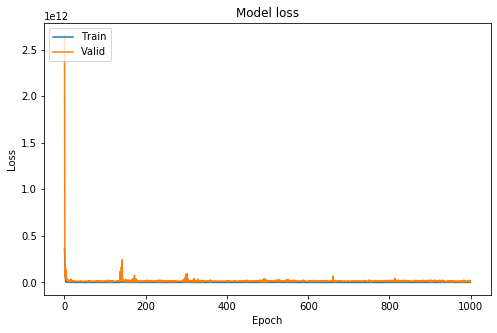

In [19]:
plt.figure(figsize=(8,5))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [20]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
#pyplot(history['train'], color = 'blue')
#pyplot(history['test'], color = 'orange')
yPredVanilla = yPredListList 
#Test MAPE: 2.3958572657092048
#Test MdSA: 2.381256736612707

Test MAPE: 2.3958572657092048
Test MdSA: 2.381256736612707


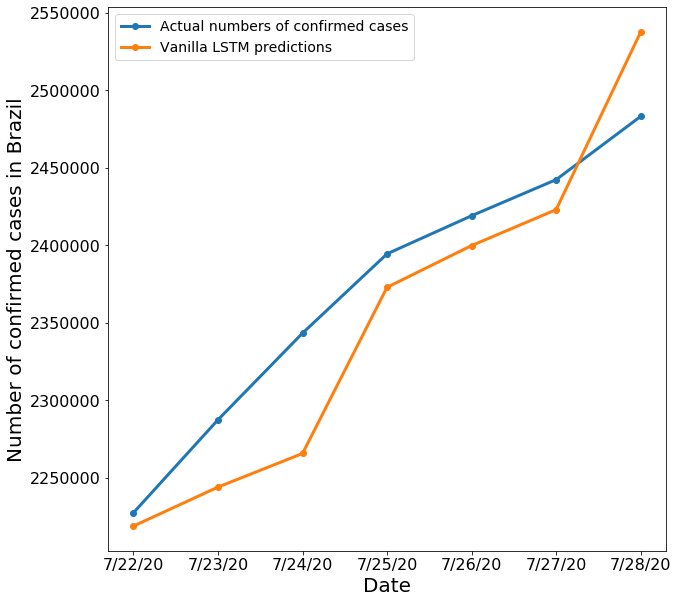

In [21]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in Brazil', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual numbers of confirmed cases');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
#plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
#plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
#ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
#plt.savefig(os.path.join('Plots_3days_k7', 'predictions_{}.png'.format(countryName)), dpi=400)

In [ ]:
dates = datesForPlottingList_df
actual = groundTruthList_df
predicted_vanilla = yPredVanilla_df
datesForPlottingList
groundTruthList

In [ ]:
datesForPlottingList
groundTruthList
yPredVanilla
allvalues = {
    'Date': ['7/22/20', '7/23/20', '7/24/20', '7/25/20', '7/26/20', '7/27/20', '7/28/20'],
    'Actual':[2227514, 2287475, 2343366, 2394513, 2419091, 2442375, 2483191],
    'Predicted_Vanilla': [2180853.5, 2226398.0, 2271696.8, 2322621.0, 2372816.0, 2423876.2, 2476557.5]}

In [ ]:
allvalues = pd.DataFrame (allvalues, columns = ['Date', 'Actual', 'Predicted_Vanilla'])
allvalues.to_csv('brazil_3d_k3_vanilla.csv')
allvalues

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

# Stacked LSTM

In [22]:
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
    model.add(LSTM(nNeurons, activation='relu'))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)
        
        
#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)

    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
        
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
model.add(LSTM(nNeurons, activation='relu'))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history1 = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 15.14490214339913
Updating best MAPE to 15.14490214339913...
Updating best seed to 0...
1 9.750826402232567
Updating best MAPE to 9.750826402232567...
Updating best seed to 1...
2 79.80204125680152
3 3.2835150690101362
Updating best MAPE to 3.2835150690101362...
Updating best seed to 3...
4 79.59390834912067
5 11.229492017540933
6 3.4449273570548535
7 78.51286611892634
8 5.476439610366747
9 6.654853207279731
10 7.148403752967279
11 80.42724760467983
12 79.81453902926039
13 2.2205410496248468
Updating best MAPE to 2.2205410496248468...
Updating best seed to 13...
14 2.0910603366982574
Updating best MAPE to 2.0910603366982574...
Updating best seed to 14...
15 8.215298528443627
16 80.44063997695682
17 4.998834283332211
18 7.567752705367454
19 34.595320782576415
20 78.80615640929234
21 7.511405682795009
22 17.15763452812879
23 2.4663416441262425
24 80.13670678875481
25 3.5319250945832166
26 6.491417396735478
27 4.9777913908084885
28 27.34593386859886
29 7.639380024104811
30 79.8408036989

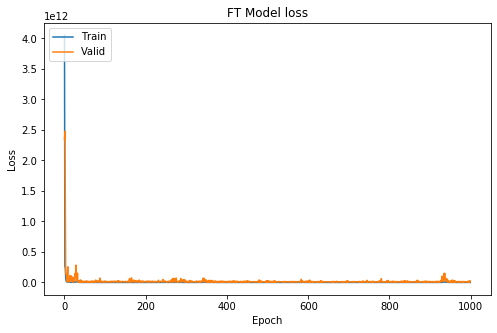

In [23]:
#diagnostic plots
plt.figure(figsize=(8,5))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('FT Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [24]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
yPredStacked = yPredListList

Test MAPE: 2.2236836348541695
Test MdSA: 2.205358221181689


# Bi-directional LSTM

In [26]:
# define model
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history1 = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 17.22721905563627
Updating best MAPE to 17.22721905563627...
Updating best seed to 0...
1 10.038098590448119
Updating best MAPE to 10.038098590448119...
Updating best seed to 1...
2 4.152640145675135
Updating best MAPE to 4.152640145675135...
Updating best seed to 2...
3 5.447886992504053
4 2.1976040675964494
Updating best MAPE to 2.1976040675964494...
Updating best seed to 4...
5 6.249700844753474
6 11.409821953961492
7 7.359081971375192
8 6.027352902799795
9 3.696987535894294
10 6.0194405668448985
11 4.150056304204301
12 11.412589519389668
13 4.936190229560021
14 2.013876346842669
Updating best MAPE to 2.013876346842669...
Updating best seed to 14...
15 6.56539114958049
16 4.714066694784111
17 3.5351934280075037
18 3.3093267018053742
19 22.521269343098318
20 2.3144372588690056
21 4.772885457208397
22 9.808253782828785
23 1.6365787353379062
Updating best MAPE to 1.6365787353379062...
Updating best seed to 23...
24 21.79358129914287
25 3.289049925641504
26 2.810716002687691
27 6.3201

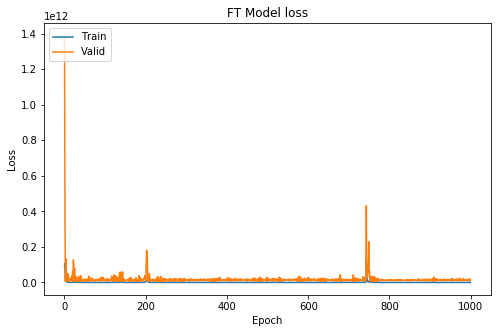

In [27]:
#diagnostic plots
plt.figure(figsize=(8,5))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('FT Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [28]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
yPredBidirectional = yPredListList

Test MAPE: 1.5359053404667005
Test MdSA: 1.4750684183026117


In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Format y tick labels
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                        return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

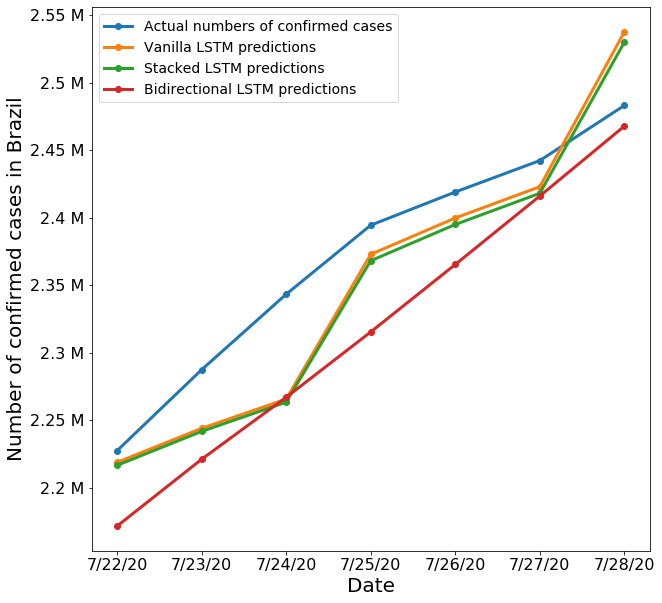

In [31]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in Brazil', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual numbers of confirmed cases');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
plt.savefig(os.path.join('Plots_3days_k7_new', 'predictions_{}.png'.format(countryName)), dpi=400)
plt.savefig(os.path.join('Plots_3days_k7_new', 'predictions_{}.pdf'.format(countryName)), dpi=400)

In [32]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla)
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked)
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional)
print('Test RMSE:', RMSE)
#Test RMSE: 263064.5062898545
#Test RMSE: 265956.2098862175
#Test RMSE: 277117.86366544414

Test RMSE: 263064.5062898545
Test RMSE: 265956.2098862175
Test RMSE: 277117.86366544414


In [33]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional[-1])
print('Test RMSE:', RMSE)
#Test RMSE: 41684.23866499611
#Test RMSE: 42491.99393772398
#Test RMSE: 57813.630769713694

Test RMSE: 41684.23866499611
Test RMSE: 42491.99393772398
Test RMSE: 57813.630769713694


In [34]:
groundTruthList
#[2227514, 2287475, 2343366, 2394513, 2419091, 2442375, 2483191]

[2227514, 2287475, 2343366, 2394513, 2419091, 2442375, 2483191]

In [35]:
 yPredVanilla[-1]
    #[2218907.8, 2244068.8, 2265730.5, 2372945.2, 2399851.2, 2423015.0, 2537665.2]

[2218907.8, 2244068.8, 2265730.5, 2372945.2, 2399851.2, 2423015.0, 2537665.2]

In [36]:
 yPredStacked[-1]
    #[2216685.0, 2241819.8, 2263459.5, 2368190.0, 2395040.5, 2418157.0, 2530035.8]

[2216685.0, 2241819.8, 2263459.5, 2368190.0, 2395040.5, 2418157.0, 2530035.8]

In [37]:
yPredBidirectional[-1]
#[2171686.8, 2221167.8, 2267036.8, 2315445.5, 2365418.5, 2416110.5, 2467855.0]

[2171686.8, 2221167.8, 2267036.8, 2315445.5, 2365418.5, 2416110.5, 2467855.0]